Importando bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 300

Definindo constantes

In [2]:
# Quantas corridas utilizadas para o histórico? (Valor de n)
PREVIOUS_RESULTS_USED = 5
# Janela aceitável de resultado para tratamento de NaNs e nulls
# Por padrão, 1 a mais que a metade
ACCEPTABLE_WINDOW = (PREVIOUS_RESULTS_USED + 1)//2
# Primeira corrida utilizada, para evitar influência de resultados muito antigos
FIRST_ACCEPTED_RACE_NUMBER = 840 # Or None

Carregando tabelas utilizadas

In [3]:
raw_dfs = {
    'races': pd.read_parquet('.data_parquet/races.parquet'),
    'results': pd.read_parquet('.data_parquet/results.parquet'),
    'driver_standings': pd.read_parquet('.data_parquet/driver_standings.parquet'),
    'constructor_standings': pd.read_parquet('.data_parquet/constructor_standings.parquet'),
    'qualifying': pd.read_parquet('.data_parquet/qualifying.parquet')
}
display(raw_dfs['races'])

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,datetime
raceId,,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-03-29 06:00:00
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-05 09:00:00
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-19 07:00:00
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-26 12:00:00
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-05-10 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00,2023-10-22 19:00:00
1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N,2023-10-29 20:00:00
1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00,2023-11-05 17:00:00


Obtendo número de cada corrida em ordem cronológica, disponibilizando essa informação a partir do `raceId`

In [4]:
races_by_number = raw_dfs['races'][['year', 'round']].sort_values(['year', 'round'])
races_by_number['number'] = range(1, len(races_by_number) + 1)
races_number = races_by_number[['number']]
races_df_with_number = raw_dfs['races'].join(races_by_number['number'], on='raceId')
display(races_df_with_number)

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,datetime,number
raceId,,,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-03-29 06:00:00,804
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-05 09:00:00,805
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-19 07:00:00,806
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-26 12:00:00,807
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-05-10 12:00:00,808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00,2023-10-22 19:00:00,1097
1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N,2023-10-29 20:00:00,1098
1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00,2023-11-05 17:00:00,1099


Para tratar `grid=0` futuramente, iremos contar a quantidade total de pilotos em cada corrida.

In [5]:
driver_count_per_race = raw_dfs['results'].groupby('raceId')['grid'].count().rename('count')
races_df_with_number = races_df_with_number.join(other=driver_count_per_race, on='raceId')
races_df_with_number

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,datetime,number,count
raceId,,,,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-03-29 06:00:00,804,20.0
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-05 09:00:00,805,20.0
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-19 07:00:00,806,20.0
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-26 12:00:00,807,20.0
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-05-10 12:00:00,808,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00,2023-10-22 19:00:00,1097,NaN
1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N,2023-10-29 20:00:00,1098,NaN
1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00,2023-11-05 17:00:00,1099,NaN


# Preparação do conjunto de dados para predição

Foram pensados os seguintes parâmetros
- Últimas posições de largada do piloto
- Últimas posições de chegada do piloto
- Histórico de classificação do piloto
- Posição "média" de largada da equipe nas últimas corridas
- Posição "média" de chegada da equipe nas últimas corridas
- Histórico de classificação da equipe

Abaixo, iremos agrupar todas essas informações no _DataFrame_ de resultados

In [6]:
# DataFrame base
results_df = raw_dfs['results']
# Renomeando colunas do DataFrame de campeonato de pilotos
joined_driver_standings_df = (
    raw_dfs['driver_standings'][['position']].rename(
        columns={'position': 'driver_standings_position'}
    )
)
# O mesmo para o campeonato de construtores
joined_constructor_standings_df = (
    raw_dfs['constructor_standings'][['position']].rename(
        columns={'position': 'constructor_standings_position'}
    )
)
# E para o DataFrame de corridas
joined_race_df = (
    races_df_with_number[['number', 'year', 'count']]
)
# Realizando joins
results_df = results_df.join(joined_driver_standings_df)
results_df = results_df.join(joined_constructor_standings_df, on=['raceId', 'constructorId'])
results_df = results_df.join(joined_race_df)
# Filtrando por número da primeira corrida aceita caso presente
if FIRST_ACCEPTED_RACE_NUMBER is not None:
    results_df = results_df.query('number >= @@FIRST_ACCEPTED_RACE_NUMBER').copy()
# Atualizando índice para ser piloto|número da corrida (em ordem)
results_df = results_df.reset_index()
results_df = results_df.set_index(['driverId', 'number'])
results_df['driverId'] = results_df.index.get_level_values(0)
results_df = results_df.sort_index()
# Realizando shift
results_df['driverId_shifted'] = results_df.groupby(level=0)['driverId'].shift(PREVIOUS_RESULTS_USED)
results_df['driverId_equals'] = results_df['driverId'] == results_df['driverId_shifted']
results_df['year_shifted'] = results_df['year'].shift(PREVIOUS_RESULTS_USED)
results_df['year_equals'] = results_df['year'] == results_df['year_shifted']
results_df.loc[results_df['grid'] == 0, 'grid'] = results_df.loc[results_df['grid'] == 0, 'count']
display(results_df)

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ...  \
driverId number                                                 ...   
1        840        5392556.0        41.0   8.0       1:30.314  ...   
         841        5929789.0        54.0   5.0       1:41.512  ...   
         842        5818226.0        48.0   2.0       1:40.415  ...   
         843        5457790.0        48.0   4.0       1:30.108  ...   
         844        5943931.0        52.0   1.0       1:26.727  ...   
...                       ...         ...   ...            ...  ...   
858      1087             NaN         4.0  20.0       1:18.437  ...   
         1088             NaN        45.0  12.0       1:09.611  ...   
         1089       5140570.0        42.0  13.0       1:31.699  ...   
         1090             NaN        36.0  12.0       1:23.496  ...   
         1091       5054926.0        37.0   9.0       1:50.486  ...   

                fastestLapMillis  driver_standings_position  \
driverId number                                               
1        840             90314.0                        2.0   
         841            101512.0                        3.0   
         842            100415.0                        2.0   
         843             90108.0                        2.0   
         844             86727.0                        2.0   
...                          ...                        ...   
858      1087            78437.0                       20.0   
         1088            69611.0                       19.0   
         1089            91699.0                       19.0   
         1090            83496.0                       19.0   
         1091           110486.0                       19.0   

                 constructor_standings_position  year  count  driverId  \
driverId number                                                          
1        840                                2.0  2011   24.0         1   
         841                                2.0  2011   24.0         1   
         842                                2.0  2011   24.0         1   
         843                                2.0  2011   24.0         1   
         844                                2.0  2011   24.0         1   
...                                         ...   ...    ...       ...   
858      1087                               9.0  2023   20.0       858   
         1088                               9.0  2023   20.0       858   
         1089                               7.0  2023   20.0       858   
         1090                               7.0  2023   20.0       858   
         1091                               7.0  2023   20.0       858   

                 driverId_shifted  driverId_equals  year_shifted  year_equals  
driverId number                                                                
1        840                  NaN            False           NaN        False  
         841                  NaN            False           NaN        False  
         842                  NaN            False   

Abaixo, iremos construir um DataFrame temporário que contém o desempenho "equivalente" da equipe do piloto a cada resultado

In [7]:
tmp_df = raw_dfs['results']
tmp_df = tmp_df.reset_index()
tmp_df = tmp_df.set_index(['raceId', 'constructorId']).sort_index()
tmp_df = (
    tmp_df
    .groupby(['raceId', 'constructorId'])
    [['grid', 'position']]
    .mean()
)
tmp_df = tmp_df.rename(columns={
    'grid': 'equivalent_grid_constructor',
    'position': 'equivalent_position_constructor'
})
results_df = results_df.join(tmp_df, on=['raceId', 'constructorId'])
results_df

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ...  \
driverId number                                                 ...   
1        840        5392556.0        41.0   8.0       1:30.314  ...   
         841        5929789.0        54.0   5.0       1:41.512  ...   
         842        5818226.0        48.0   2.0       1:40.415  ...   
         843        5457790.0        48.0   4.0       1:30.108  ...   
         844        5943931.0        52.0   1.0       1:26.727  ...   
...                       ...         ...   ...            ...  ...   
858      1087             NaN         4.0  20.0       1:18.437  ...   
         1088             NaN        45.0  12.0       1:09.611  ...   
         1089       5140570.0        42.0  13.0       1:31.699  ...   
         1090             NaN        36.0  12.0       1:23.496  ...   
         1091       5054926.0        37.0   9.0       1:50.486  ...   

                constructor_standings_position  year  count  driverId  \
driverId number                                                         
1        840                               2.0  2011   24.0         1   
         841                               2.0  2011   24.0         1   
         842                               2.0  2011   24.0         1   
         843                               2.0  2011   24.0         1   
         844                               2.0  2011   24.0         1   
...                                        ...   ...    ...       ...   
858      1087                              9.0  2023   20.0       858   
         1088                              9.0  2023   20.0       858   
         1089                              7.0  2023   20.0       858   
         1090                              7.0  2023   20.0       858   
         1091                              7.0  2023   20.0       858   

                 driverId_shifted  driverId_equals  year_shifted  year_equals  \
driverId number                                                                 
1        840                  NaN            False           NaN        False   
         841                  NaN            False           NaN        False   
         842                  NaN            False           NaN        False   
         843                  NaN            False           NaN        False   
         844                  NaN            False           NaN        False   
...                           ...              ...           ...          ...   
858      1087               858.0             True        2023.0         True   
         1088               858.0             True        2023.0         True   
         1089               858.0             True        2023.0         True   
         1090               858.0             True        2023.0         True   
         1091               858.0             True        2023.0         True   

                 equivalent_grid_constructor  equivalent_position_constructor  
driverId number                                                         

Abaixo, iremos construir outro DataFrame temporário para fazer uma janela de valores com $n$ valores cada. Iremos calcular a média e o desvio padrão dessa janela para descrever o comportamento do contexto recente. O `shift` é necessário para impedir que o modelo se torne viciado.

In [8]:
tmp2_df = (
    results_df[[
        'grid',
        'equivalent_grid_constructor',
    ]]
    .rolling(PREVIOUS_RESULTS_USED)
    .agg(['mean', 'std'])
    .rename(columns={
        'grid': 'grid_driver'
    })
).shift(1)
tmp2_df.columns = ['_'.join(col).strip() for col in tmp2_df.columns.values]
display(tmp2_df.head(10))

grid_driver_mean  grid_driver_std  \
driverId number                                      
1        840                  NaN              NaN   
         841                  NaN              NaN   
         842                  NaN              NaN   
         843                  NaN              NaN   
         844                  NaN              NaN   
         845                  2.8         0.836660   
         846                  4.2         2.774887   
         847                  4.8         2.489980   
         848                  4.8         2.489980   
         849                  6.0         3.316625   

                 equivalent_grid_constructor_mean  \
driverId number                                     
1        840                                  NaN   
         841                                  NaN   
         842                                  NaN   
         843                                  NaN   
         844                                  NaN   
         845                                  3.5   
         846                                  4.0   
         847                                  4.6   
         848                                  5.0   
         849                                  5.5   

                 equivalent_grid_constructor_std  
driverId number                                   
1        840                                 NaN  
         841                                 NaN  
         842                                 NaN  
         843                                 NaN  
         844                                 NaN  
         845                            1.000000  
         846                            1.274755  
         847                            1.387444  
         848                            0.790569  
         849                            1.369306

Da mesma maneira, isso é feito para a janela de posições de chegada, no entanto, aqui passamos o parâmetro `min_periods` para não perder muitos dados quando lidando com sequências de `NaN`.

In [9]:
tmp3_df = (
    results_df[[
        'position',
        'equivalent_position_constructor',
    ]]
    .rolling(PREVIOUS_RESULTS_USED, min_periods=ACCEPTABLE_WINDOW)
    .agg(['mean', 'std'])
    .rename(columns={
        'position': 'position_driver',
    })
).shift(1)
tmp3_df.columns = ['_'.join(col).strip() for col in tmp3_df.columns.values]
display(tmp3_df.head(10))

position_driver_mean  position_driver_std  \
driverId number                                              
1        840                      NaN                  NaN   
         841                      NaN                  NaN   
         842                      NaN                  NaN   
         843                 3.666667             3.785939   
         844                 3.750000             3.095696   
         845                 3.400000             2.792848   
         846                 4.200000             2.863564   
         847                 3.250000             2.217356   
         848                 4.000000             1.632993   
         849                 4.000000             1.632993   

                 equivalent_position_constructor_mean  \
driverId number                                         
1        840                                      NaN   
         841                                      NaN   
         842                                      NaN   
         843                                 3.833333   
         844                                 4.125000   
         845                                 3.800000   
         846                                 3.900000   
         847                                 3.100000   
         848                                 3.600000   
         849                                 3.400000   

                 equivalent_position_constructor_std  
driverId number                                       
1        840                                     NaN  
         841                                     NaN  
         842                                     NaN  
         843                                1.258306  
         844                                1.181454  
         845                                1.254990  
         846                                1.294218  
         847                                1.635543  
         848                                1.781853  
         849                                1.635543

Realizando o `join` dessas tabelas temporárias

In [10]:
results_df = results_df.join(tmp2_df)
results_df = results_df.join(tmp3_df)
results_df

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ...  \
driverId number                                                 ...   
1        840        5392556.0        41.0   8.0       1:30.314  ...   
         841        5929789.0        54.0   5.0       1:41.512  ...   
         842        5818226.0        48.0   2.0       1:40.415  ...   
         843        5457790.0        48.0   4.0       1:30.108  ...   
         844        5943931.0        52.0   1.0       1:26.727  ...   
...                       ...         ...   ...            ...  ...   
858      1087             NaN         4.0  20.0       1:18.437  ...   
         1088             NaN        45.0  12.0       1:09.611  ...   
         1089       5140570.0        42.0  13.0       1:31.699  ...   
         1090             NaN        36.0  12.0       1:23.496  ...   
         1091       5054926.0        37.0   9.0       1:50.486  ...   

                equivalent_grid_constructor  equivalent_position_constructor  \
driverId number                                                                
1        840                            3.0                              4.0   
         841                            3.0                              5.0   
         842                            2.5                              2.5   
         843                            5.0                              5.0   
         844                            4.0                              2.5   
...                                     ...                              ...   
858      1087                          13.5                              7.0   
         1088                          14.0                             12.0   
         1089                          11.0                              9.5   
         1090                          18.0                             11.0   
         1091                          16.5                             15.5   

                 grid_driver_mean  grid_driver_std  \
driverId number                                      
1        840                  NaN              NaN   
         841                  NaN              NaN   
         842                  NaN              NaN   
         843                  NaN              NaN   
         844                  NaN              NaN   
...                           ...              ...   
858      1087                17.6         2.607681   
         1088                17.6         2.607681   
         1089                18.4         1.673320   
         1090                17.2         2.280351   
         1091                18.0         2.449490   

                 equivalent_grid_constructor_mean  \
driverId number                                     
1        840                                  NaN   
         841                                  NaN   
         842                                  NaN   
         843                                  NaN   
         844                                  NaN   
...                                      

Por fim, temos as seguintes colunas

In [11]:
results_df.columns

Index(['raceId', 'constructorId', 'grid', 'position', 'points', 'laps',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'fastestLapMillis',
       'driver_standings_position', 'constructor_standings_position', 'year',
       'count', 'driverId', 'driverId_shifted', 'driverId_equals',
       'year_shifted', 'year_equals', 'equivalent_grid_constructor',
       'equivalent_position_constructor', 'grid_driver_mean',
       'grid_driver_std', 'equivalent_grid_constructor_mean',
       'equivalent_grid_constructor_std', 'position_driver_mean',
       'position_driver_std', 'equivalent_position_constructor_mean',
       'equivalent_position_constructor_std'],
      dtype='object')

No entanto, para a nossa matriz de resultados e ajuste do modelo, precisamos apenas de algumas delas, podendo remover valores como índices e atributos não utilizados.

In [12]:
tt_df = results_df.drop(columns=[
    'raceId', 'constructorId', 'points', 'laps',
    'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
    'fastestLapSpeed', 'statusId', 'year', 'driverId',
    'driverId_shifted', 'year_shifted', 'equivalent_grid_constructor',
    'equivalent_position_constructor', 'fastestLapMillis'
])
x_columns = tt_df.columns.difference(['position'])
y_columns = ['position']
columns_in_order = list(x_columns) + y_columns
tt_df = tt_df[columns_in_order]
tt_df.shape

(5301, 15)

Portanto, temos 5301 linhas e 15 atributos, sendo um deles o atributo que queremos prever.

Podemos filtrar quando o resultado de um piloto começa a interferir no resultado de outro e quando ocorre uma mudança de ano a partir dos shifts realizados sobre os ids anteriormente.

In [13]:
tt_df[tt_df['driverId_equals'] & tt_df['year_equals']]

constructor_standings_position  count  driverId_equals  \
driverId number                                                           
1        845                                2.0   24.0             True   
         846                                2.0   24.0             True   
         847                                2.0   24.0             True   
         848                                2.0   24.0             True   
         849                                2.0   24.0             True   
...                                         ...    ...              ...   
858      1087                               9.0   20.0             True   
         1088                               9.0   20.0             True   
         1089                               7.0   20.0             True   
         1090                               7.0   20.0             True   
         1091                               7.0   20.0             True   

                 driver_standings_position  equivalent_grid_constructor_mean  \
driverId number                                                                
1        845                           2.0                               3.5   
         846                           4.0                               4.0   
         847                           4.0                               4.6   
         848                           4.0                               5.0   
         849                           3.0                               5.5   
...                                    ...                               ...   
858      1087                         20.0                              15.0   
         1088                         19.0                              15.1   
         1089                         19.0                              15.3   
         1090                         19.0                              14.4   
         1091                         19.0                              15.1   

                 equivalent_grid_constructor_std  \
driverId number                                    
1        845                            1.000000   
         846                            1.274755   
         847                            1.387444   
         848                            0.790569   
         849                            1.369306   
...                                          ...   
858      1087                           2.474874   
         1088                           2.382226   
         1089                           2.196588   
         1090                           2.902585   
         1091                           3.324154   

                 equivalent_position_constructor_mean  \
driverId number                                         
1        845                                      3.8   
         846                                      3.9   
         847                                      3.1   
         848                                      3.6   
         849                                      3.4   
...                                               ...   
858      1087                                    16.2   
         1088                                    14.4   
         1089                                    14.0   
         1090                                    12.5   
         1091                                    11.5   

                 equivalent_position_constructor_std  grid  grid_driver_mean  \
driverId number                                                                
1        845                                1.254990     9               2.8   
         846                                1.294218     5               4.2   
         847                                1.635543     3               4.8   
         848                                1.781853    10               4.8   
         849                                1.635543     2               6.0   
...                  

In [14]:
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5301 entries, (1, 840) to (858, 1091)
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   constructor_standings_position        5295 non-null   float64
 1   count                                 5301 non-null   float64
 2   driverId_equals                       5301 non-null   bool   
 3   driver_standings_position             5297 non-null   float64
 4   equivalent_grid_constructor_mean      5296 non-null   float64
 5   equivalent_grid_constructor_std       5296 non-null   float64
 6   equivalent_position_constructor_mean  5294 non-null   float64
 7   equivalent_position_constructor_std   5294 non-null   float64
 8   grid                                  5301 non-null   int64  
 9   grid_driver_mean                      5296 non-null   float64
 10  grid_driver_std                       5296 non-null   float64
 11  pos

Não podemos passar valores nulos para o modelos, portanto iremos ignorá-los. Também iremos remover valores quando há conflito de id de piloto ou de ano.

In [15]:
tt_df[tt_df['driverId_equals'] & tt_df['year_equals']].dropna().shape

(3169, 15)

Formando o `DataFrame` de treino e teste e separando-os em duas porções, uma com 66% e outra com 33% (2/3) e (1/3)

In [16]:
tt_df = tt_df[tt_df['driverId_equals'] & tt_df['year_equals']].dropna()
tt_df = tt_df.drop(columns=['driverId_equals', 'year_equals'])
tt_size = tt_df.shape[0]
train_size = int(tt_size * (2/3))
test_size = tt_size - train_size
idxs = np.random.permutation(tt_size)
train_df = tt_df.iloc[idxs[:train_size]].copy()
test_df = tt_df.iloc[idxs[train_size:]].copy()
x_columns = tt_df.columns.difference(['position'])
y_columns = ['position']

# Ajustando o modelo de regressão de SVR Linear

In [17]:
from sklearn.svm import LinearSVR

reg = LinearSVR(dual=True, max_iter=int(1e8))
reg.fit(train_df[x_columns], train_df[y_columns])

/home/guilherme/Projects/data-science-uni/.env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(dual=True, max_iter=100000000)

Analisando o desempenho no conjunto de teste.

In [18]:
y_pred = reg.predict(test_df[x_columns])
test_df['predicted_position'] = np.clip(np.round(y_pred), a_min=1, a_max=9999)

Verificando valores dos erros médios absolutos e quadráticos.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(test_df['position'], test_df['predicted_position'])
mae = mean_absolute_error(test_df['position'], test_df['predicted_position'])
display(mse, mae)

9.618732261116367

2.216650898770104

Comparando o resultado esperado com o predito, analisando a distância entre os dois.

In [20]:
test_df['delta'] = test_df['predicted_position'] - test_df['position']

A figura gerada abaixo mostra a distribuição dos acertos e dos erros.

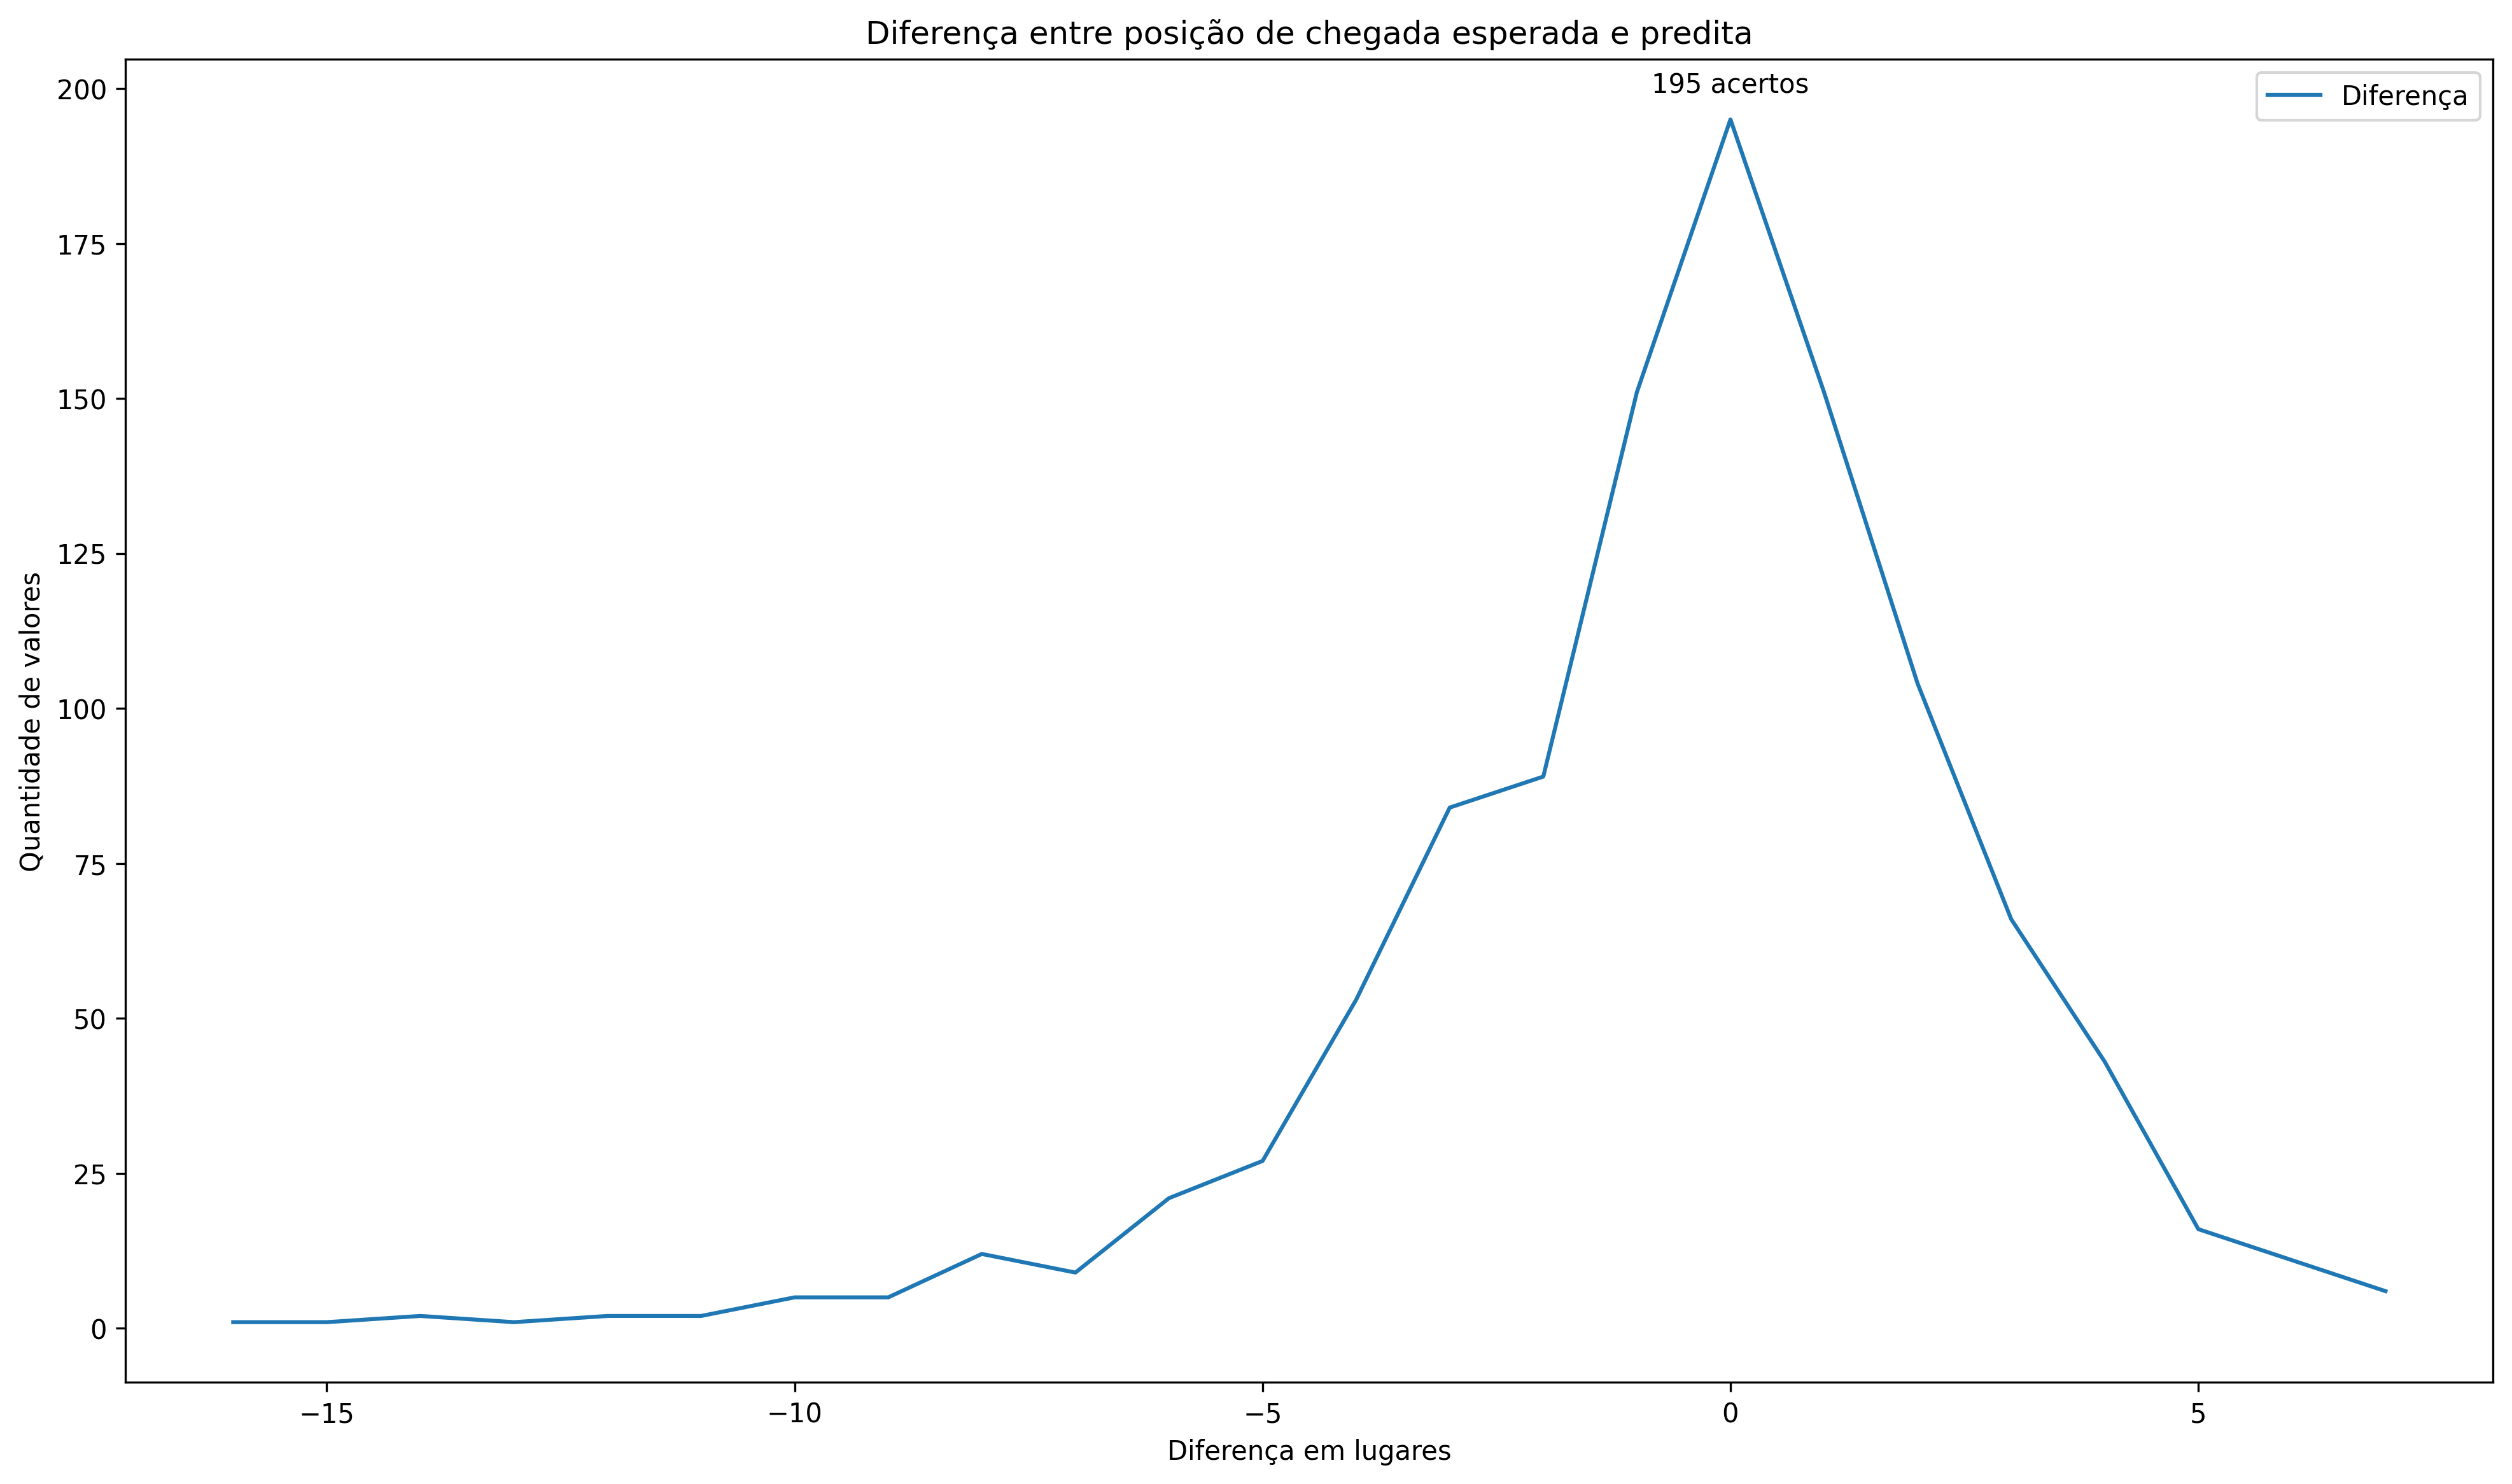

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
delta_count = test_df['delta'].value_counts().sort_index()
ax.plot(delta_count, label='Diferença')
ax.set_xlabel('Diferença em lugares')
ax.set_ylabel('Quantidade de valores')
ax.set_title('Diferença entre posição de chegada esperada e predita')
ax.annotate(f'{delta_count[0]} acertos', (0, delta_count[0]), textcoords="offset points", xytext=(0,10), ha='center')
ax.legend()
plt.savefig('.graphs/linear_svr_delta.png', dpi=300, transparent=True)
plt.show()

Agrupando os resultados esperados e verificando a média dos preditos e a diferença. É gerado um gráfico que demonstra o intervalo de confiança para cada valor predito.

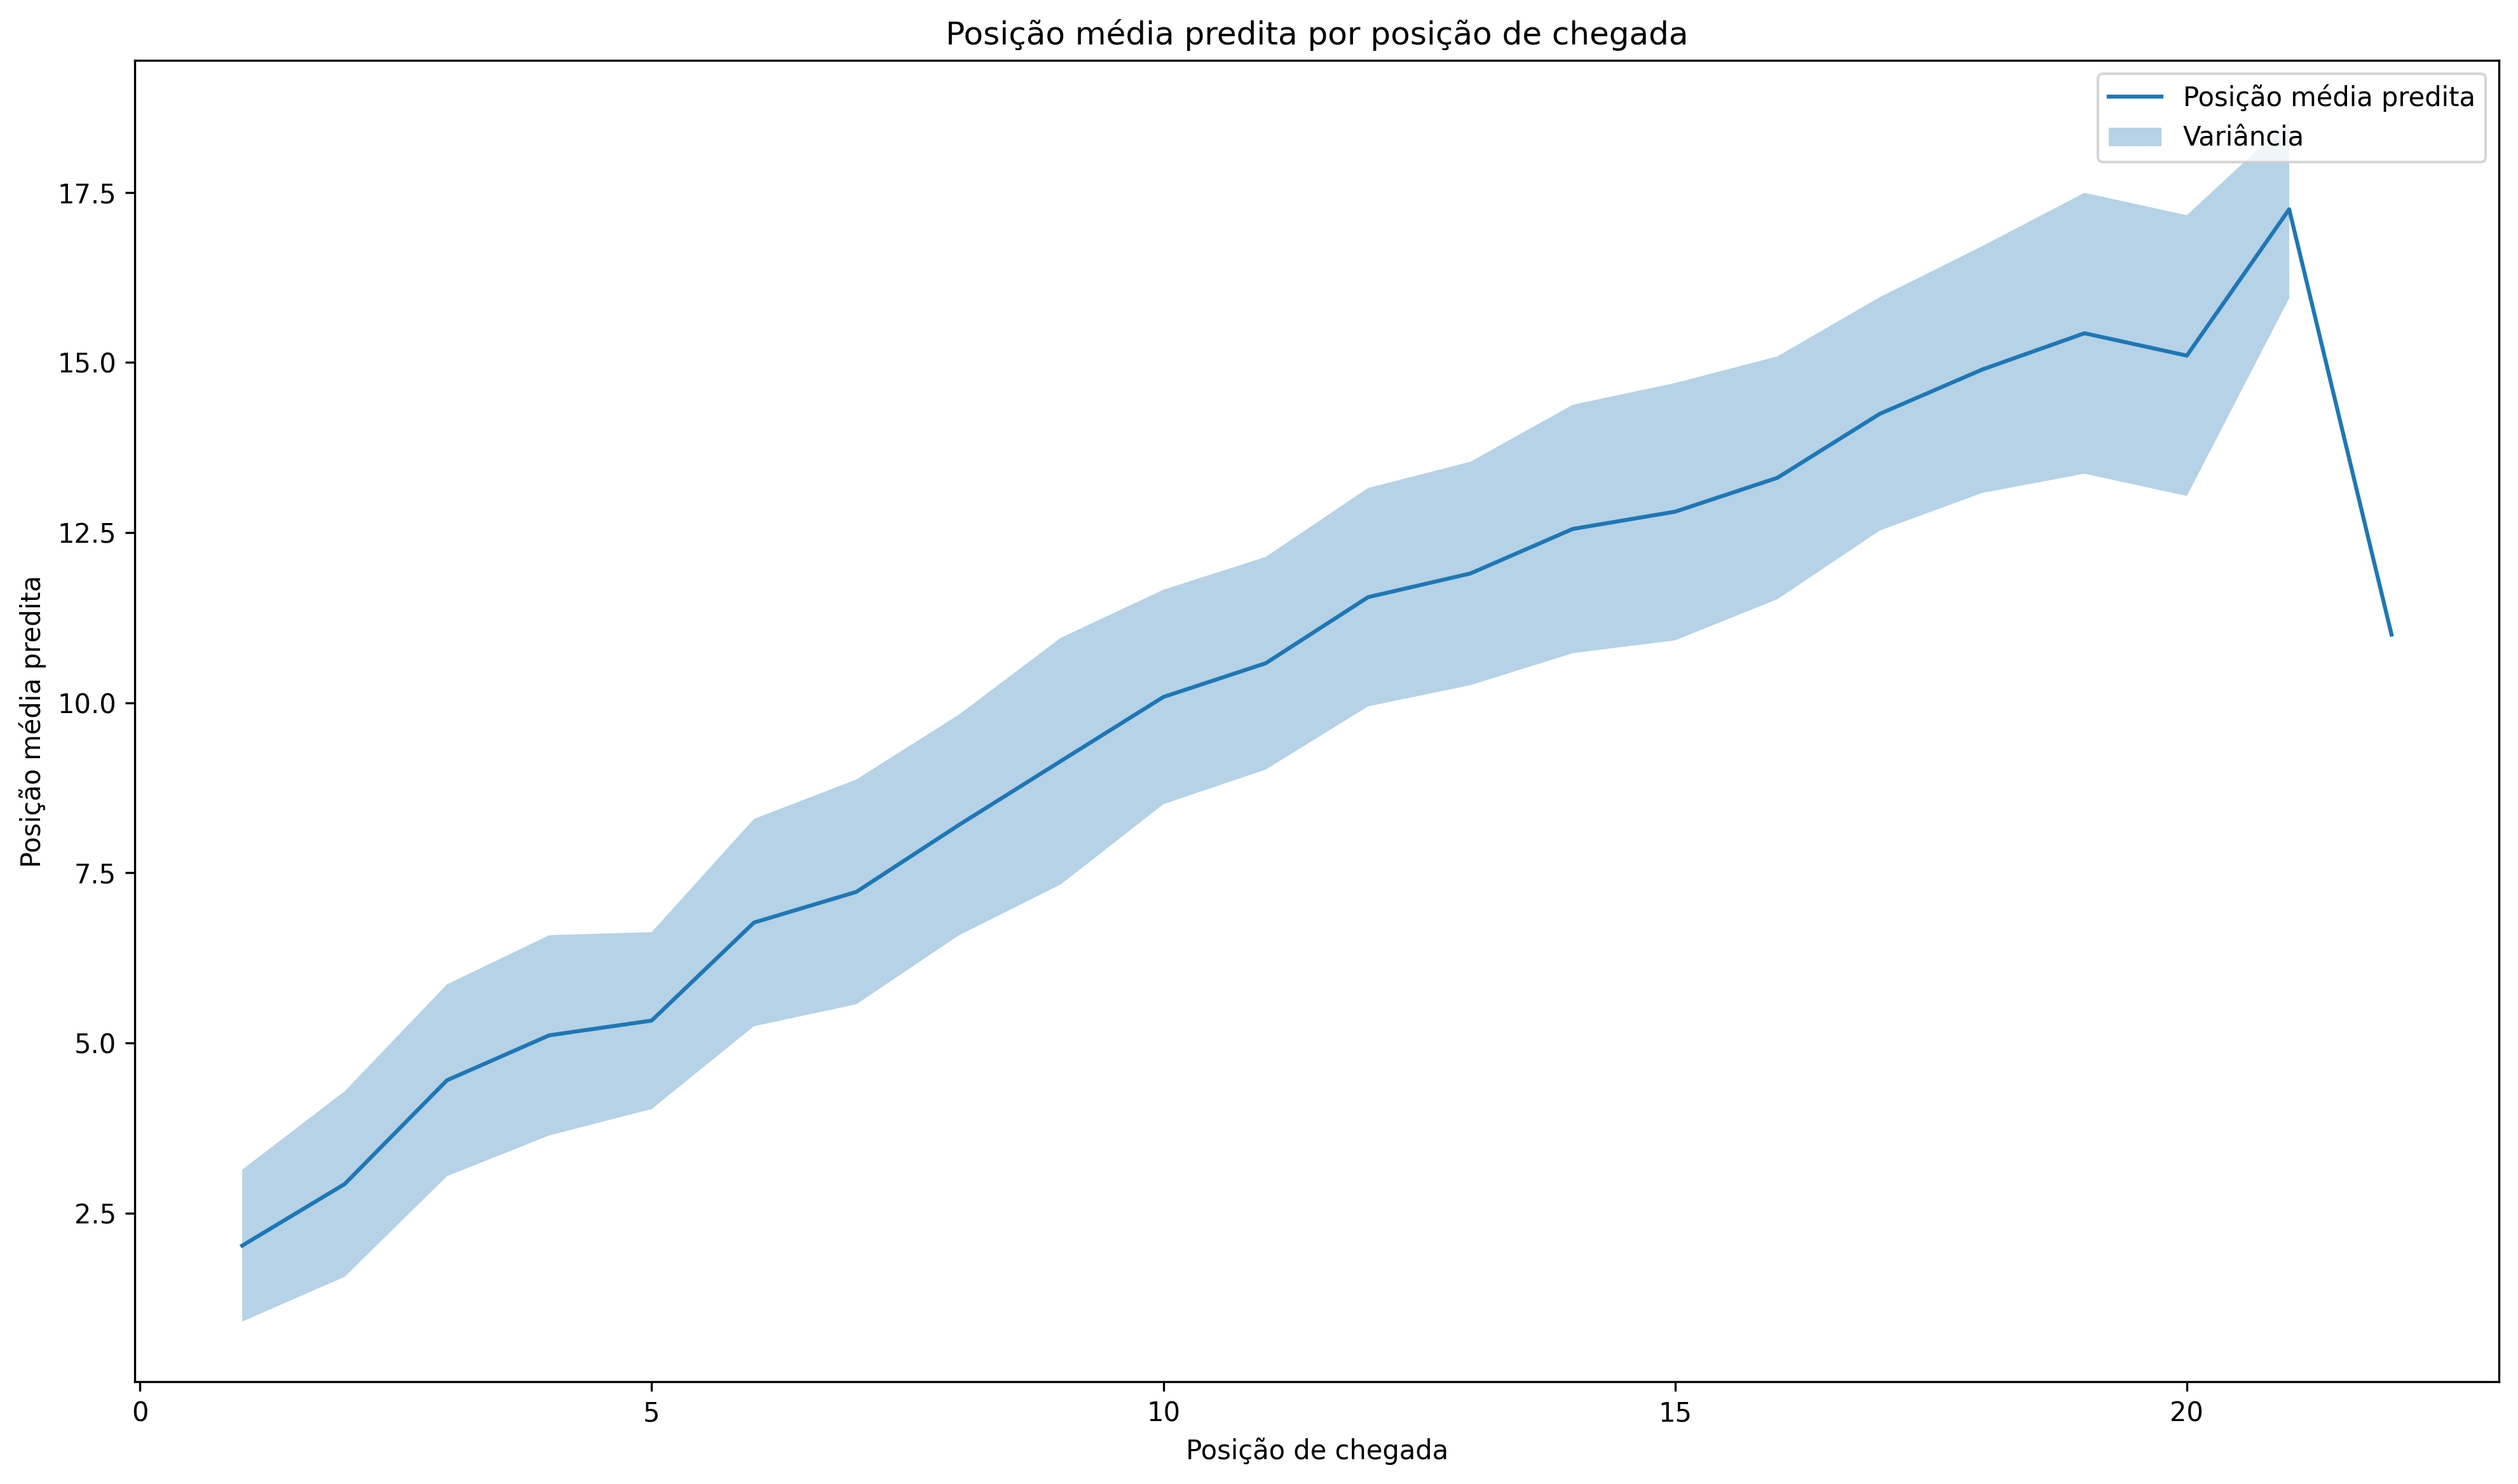

In [22]:
prediction_stats_df = (
    test_df
    .groupby('position')[['predicted_position', 'delta']]
    .agg(['mean', 'min', 'max', 'std'])
)
prediction_stats_df.columns = ['_'.join(col).strip() for col in prediction_stats_df.columns.values]

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(prediction_stats_df['predicted_position_mean'], label='Posição média predita')
ax.fill_between(
    prediction_stats_df.index,
    prediction_stats_df['predicted_position_mean'] - np.sqrt(prediction_stats_df['predicted_position_std']),
    prediction_stats_df['predicted_position_mean'] + np.sqrt(prediction_stats_df['predicted_position_std']),
    alpha=0.33,
    label='Variância'
)
ax.set_xlabel('Posição de chegada')
ax.set_ylabel('Posição média predita')
ax.set_title('Posição média predita por posição de chegada')
ax.legend()
plt.savefig('.graphs/linear_svr_mean.png', dpi=300, transparent=True)
plt.show()

Ou, caso preferir, em forma de tabela.

In [23]:
display(prediction_stats_df)

,predicted_position_mean,predicted_position_min,predicted_position_max,predicted_position_std,delta_mean,delta_min,delta_max,delta_std
position,,,,,,,,
1.0,2.020833,1.0,5.0,1.246093,1.020833,0.0,4.0,1.246093
2.0,2.924528,1.0,9.0,1.858960,0.924528,-1.0,7.0,1.858960
3.0,4.450000,2.0,10.0,1.986608,1.450000,-1.0,7.0,1.986608
4.0,5.111111,1.0,11.0,2.163563,1.111111,-3.0,7.0,2.163563
5.0,5.327273,1.0,10.0,1.689341,0.327273,-4.0,5.0,1.689341
6.0,6.767857,1.0,12.0,2.319805,0.767857,-5.0,6.0,2.319805
7.0,7.218750,1.0,14.0,2.728269,0.218750,-6.0,7.0,2.728269
8.0,8.200000,2.0,13.0,2.628398,0.200000,-6.0,5.0,2.628398
9.0,9.142857,1.0,16.0,3.283172,0.142857,-8.0,7.0,3.283172


Por fim, mostramos uma matriz de confusão para os valores esperados e preditos.

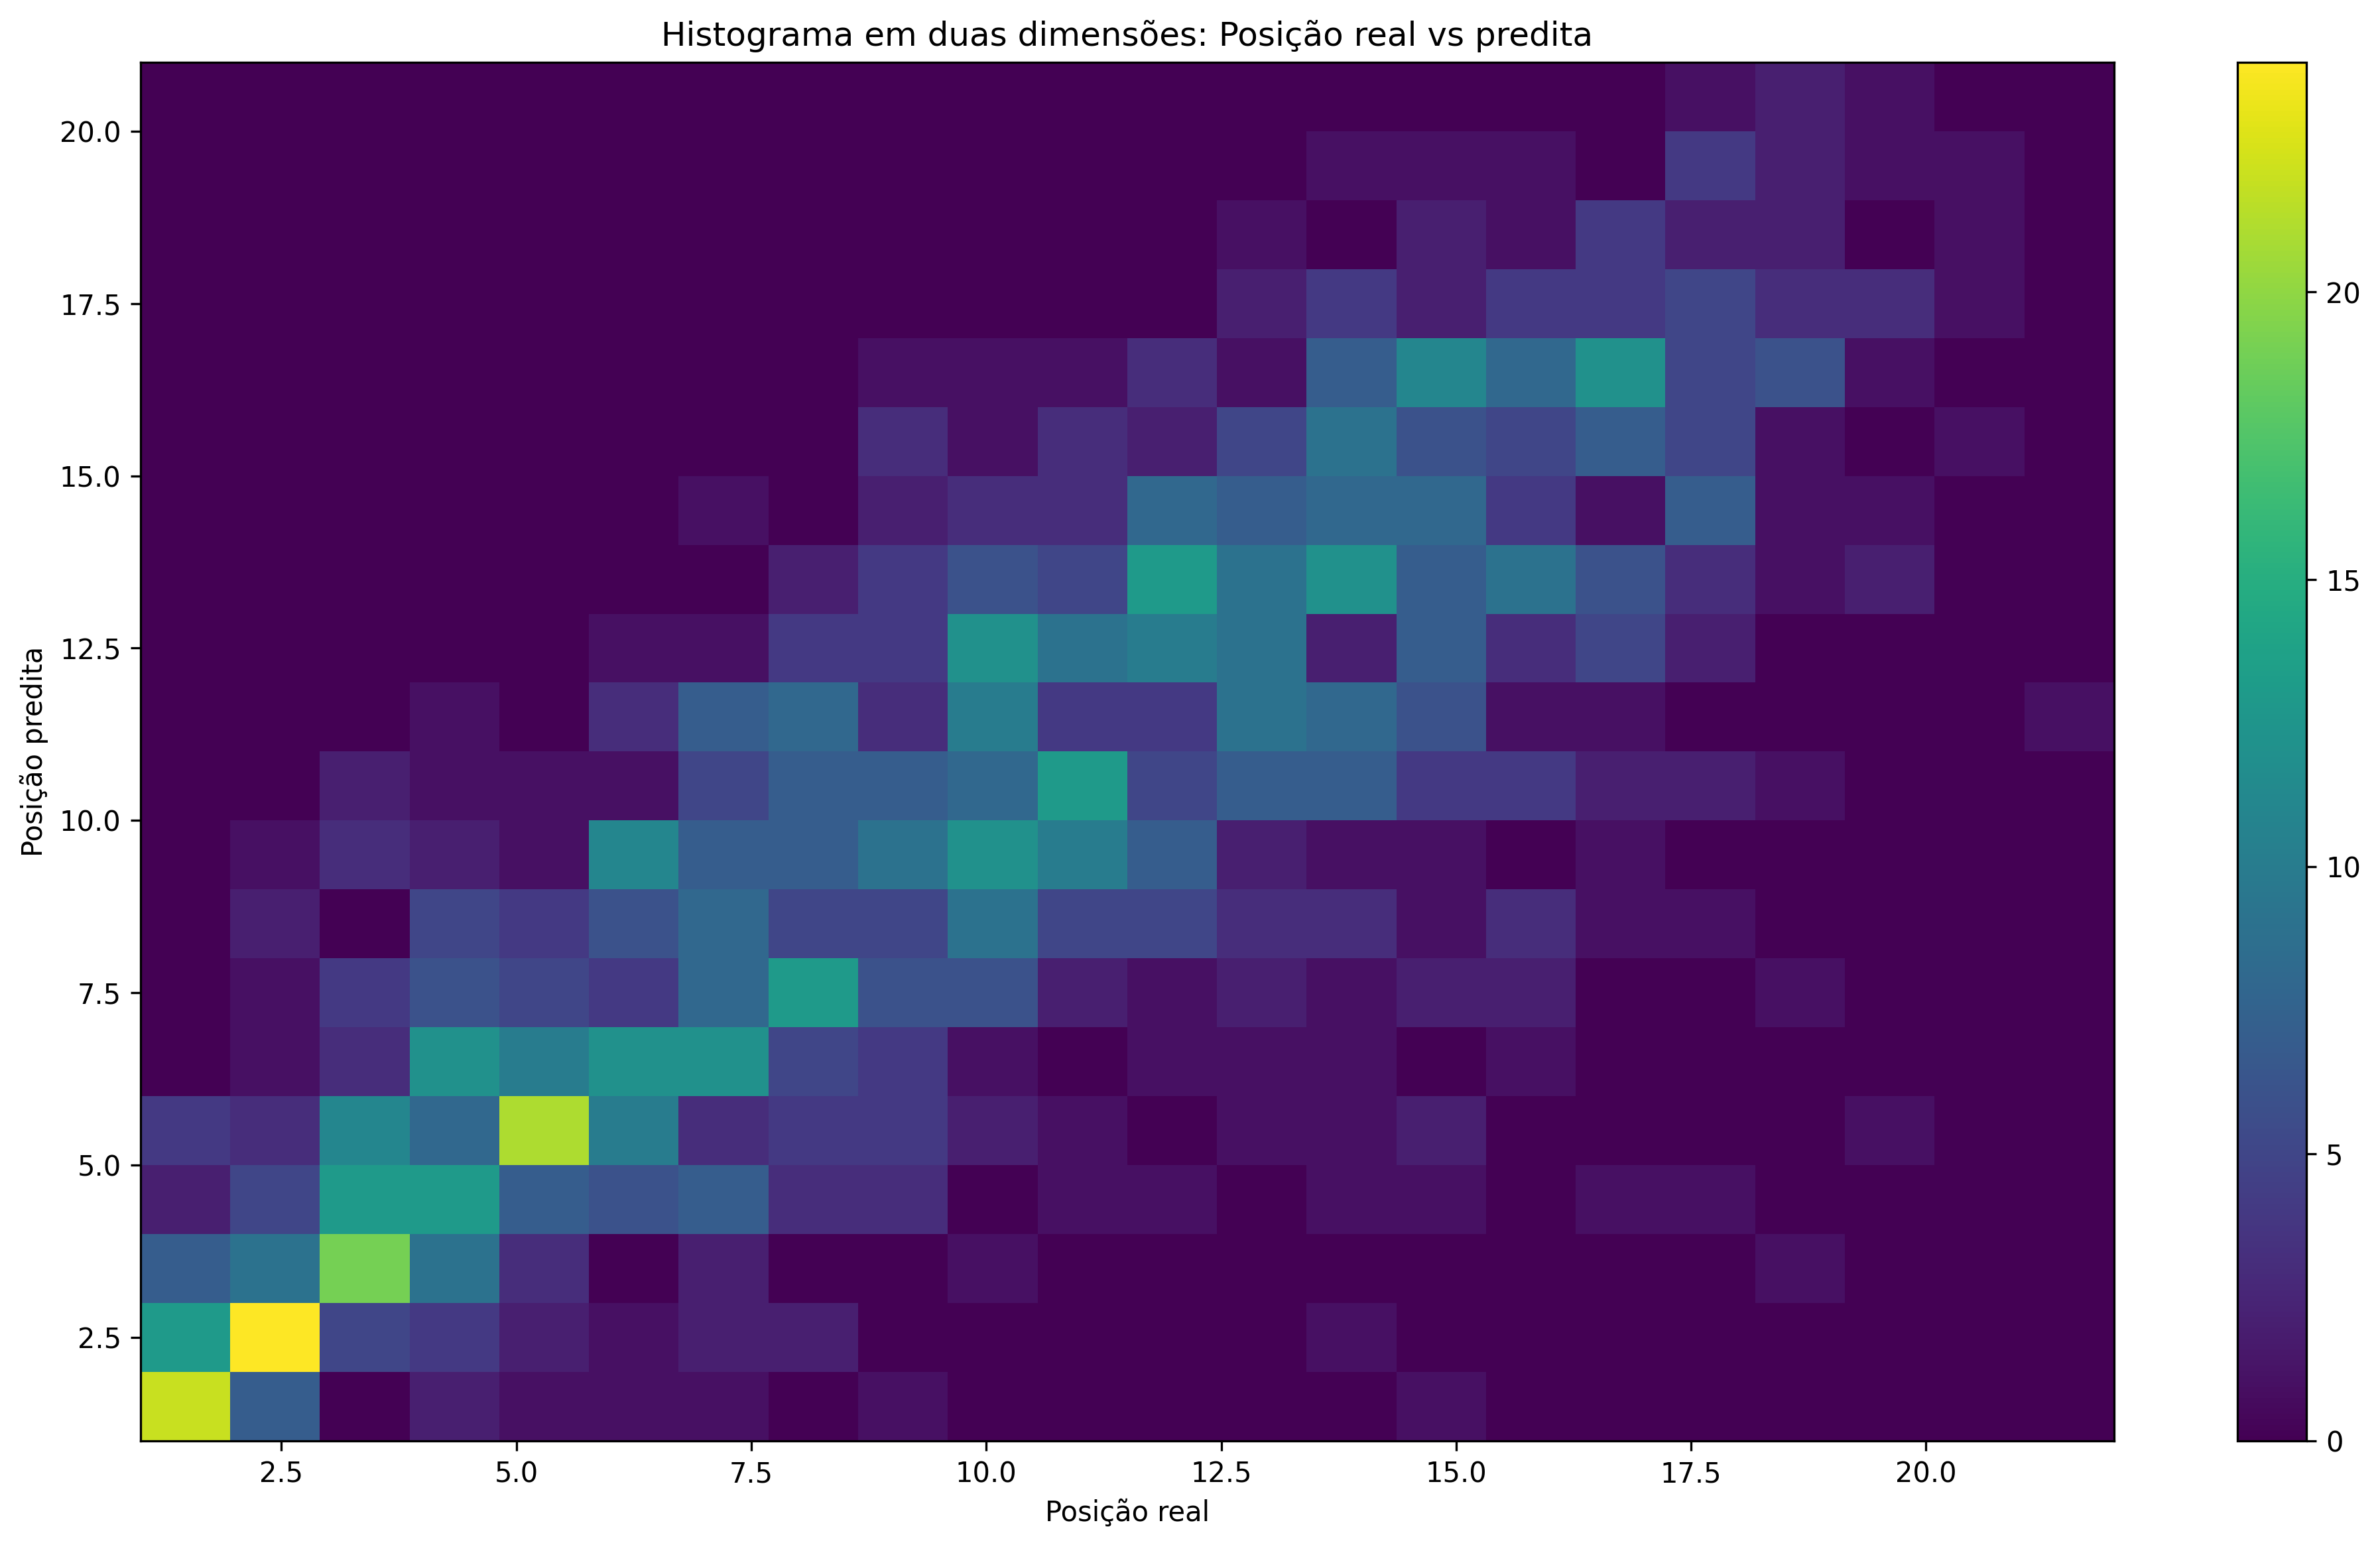

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist2d(test_df['position'], test_df['predicted_position'], bins=(22, 20))
ax.set_xlabel('Posição real')
ax.set_ylabel('Posição predita')
ax.set_title('Histograma em duas dimensões: Posição real vs predita')
cb = plt.colorbar(ax.collections[0], ax=ax)
plt.savefig('.graphs/linear_svr_hist2d.png', dpi=300, transparent=True)
plt.show()

# Ajustando o modelo de regressão de RandomForest

In [25]:
from sklearn.ensemble import RandomForestRegressor

reg2 = RandomForestRegressor()
reg2.fit(train_df[x_columns], train_df[y_columns])

/home/guilherme/Projects/data-science-uni/.env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

Analisando o desempenho no conjunto de teste.

In [26]:
y_pred2 = reg2.predict(test_df[x_columns])
test_df2 = test_df.copy()
test_df2['predicted_position'] = np.clip(np.round(y_pred2), a_min=1, a_max=9999)

Verificando valores dos erros médios absolutos e quadráticos.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(test_df2['position'], test_df2['predicted_position'])
mae = mean_absolute_error(test_df2['position'], test_df2['predicted_position'])
display(mse, mae)

9.574266792809839

2.2876064333017974

Comparando o resultado esperado com o predito, analisando a distância entre os dois.

In [28]:
test_df2['delta'] = test_df2['predicted_position'] - test_df2['position']

A figura gerada abaixo mostra a distribuição dos acertos e dos erros.

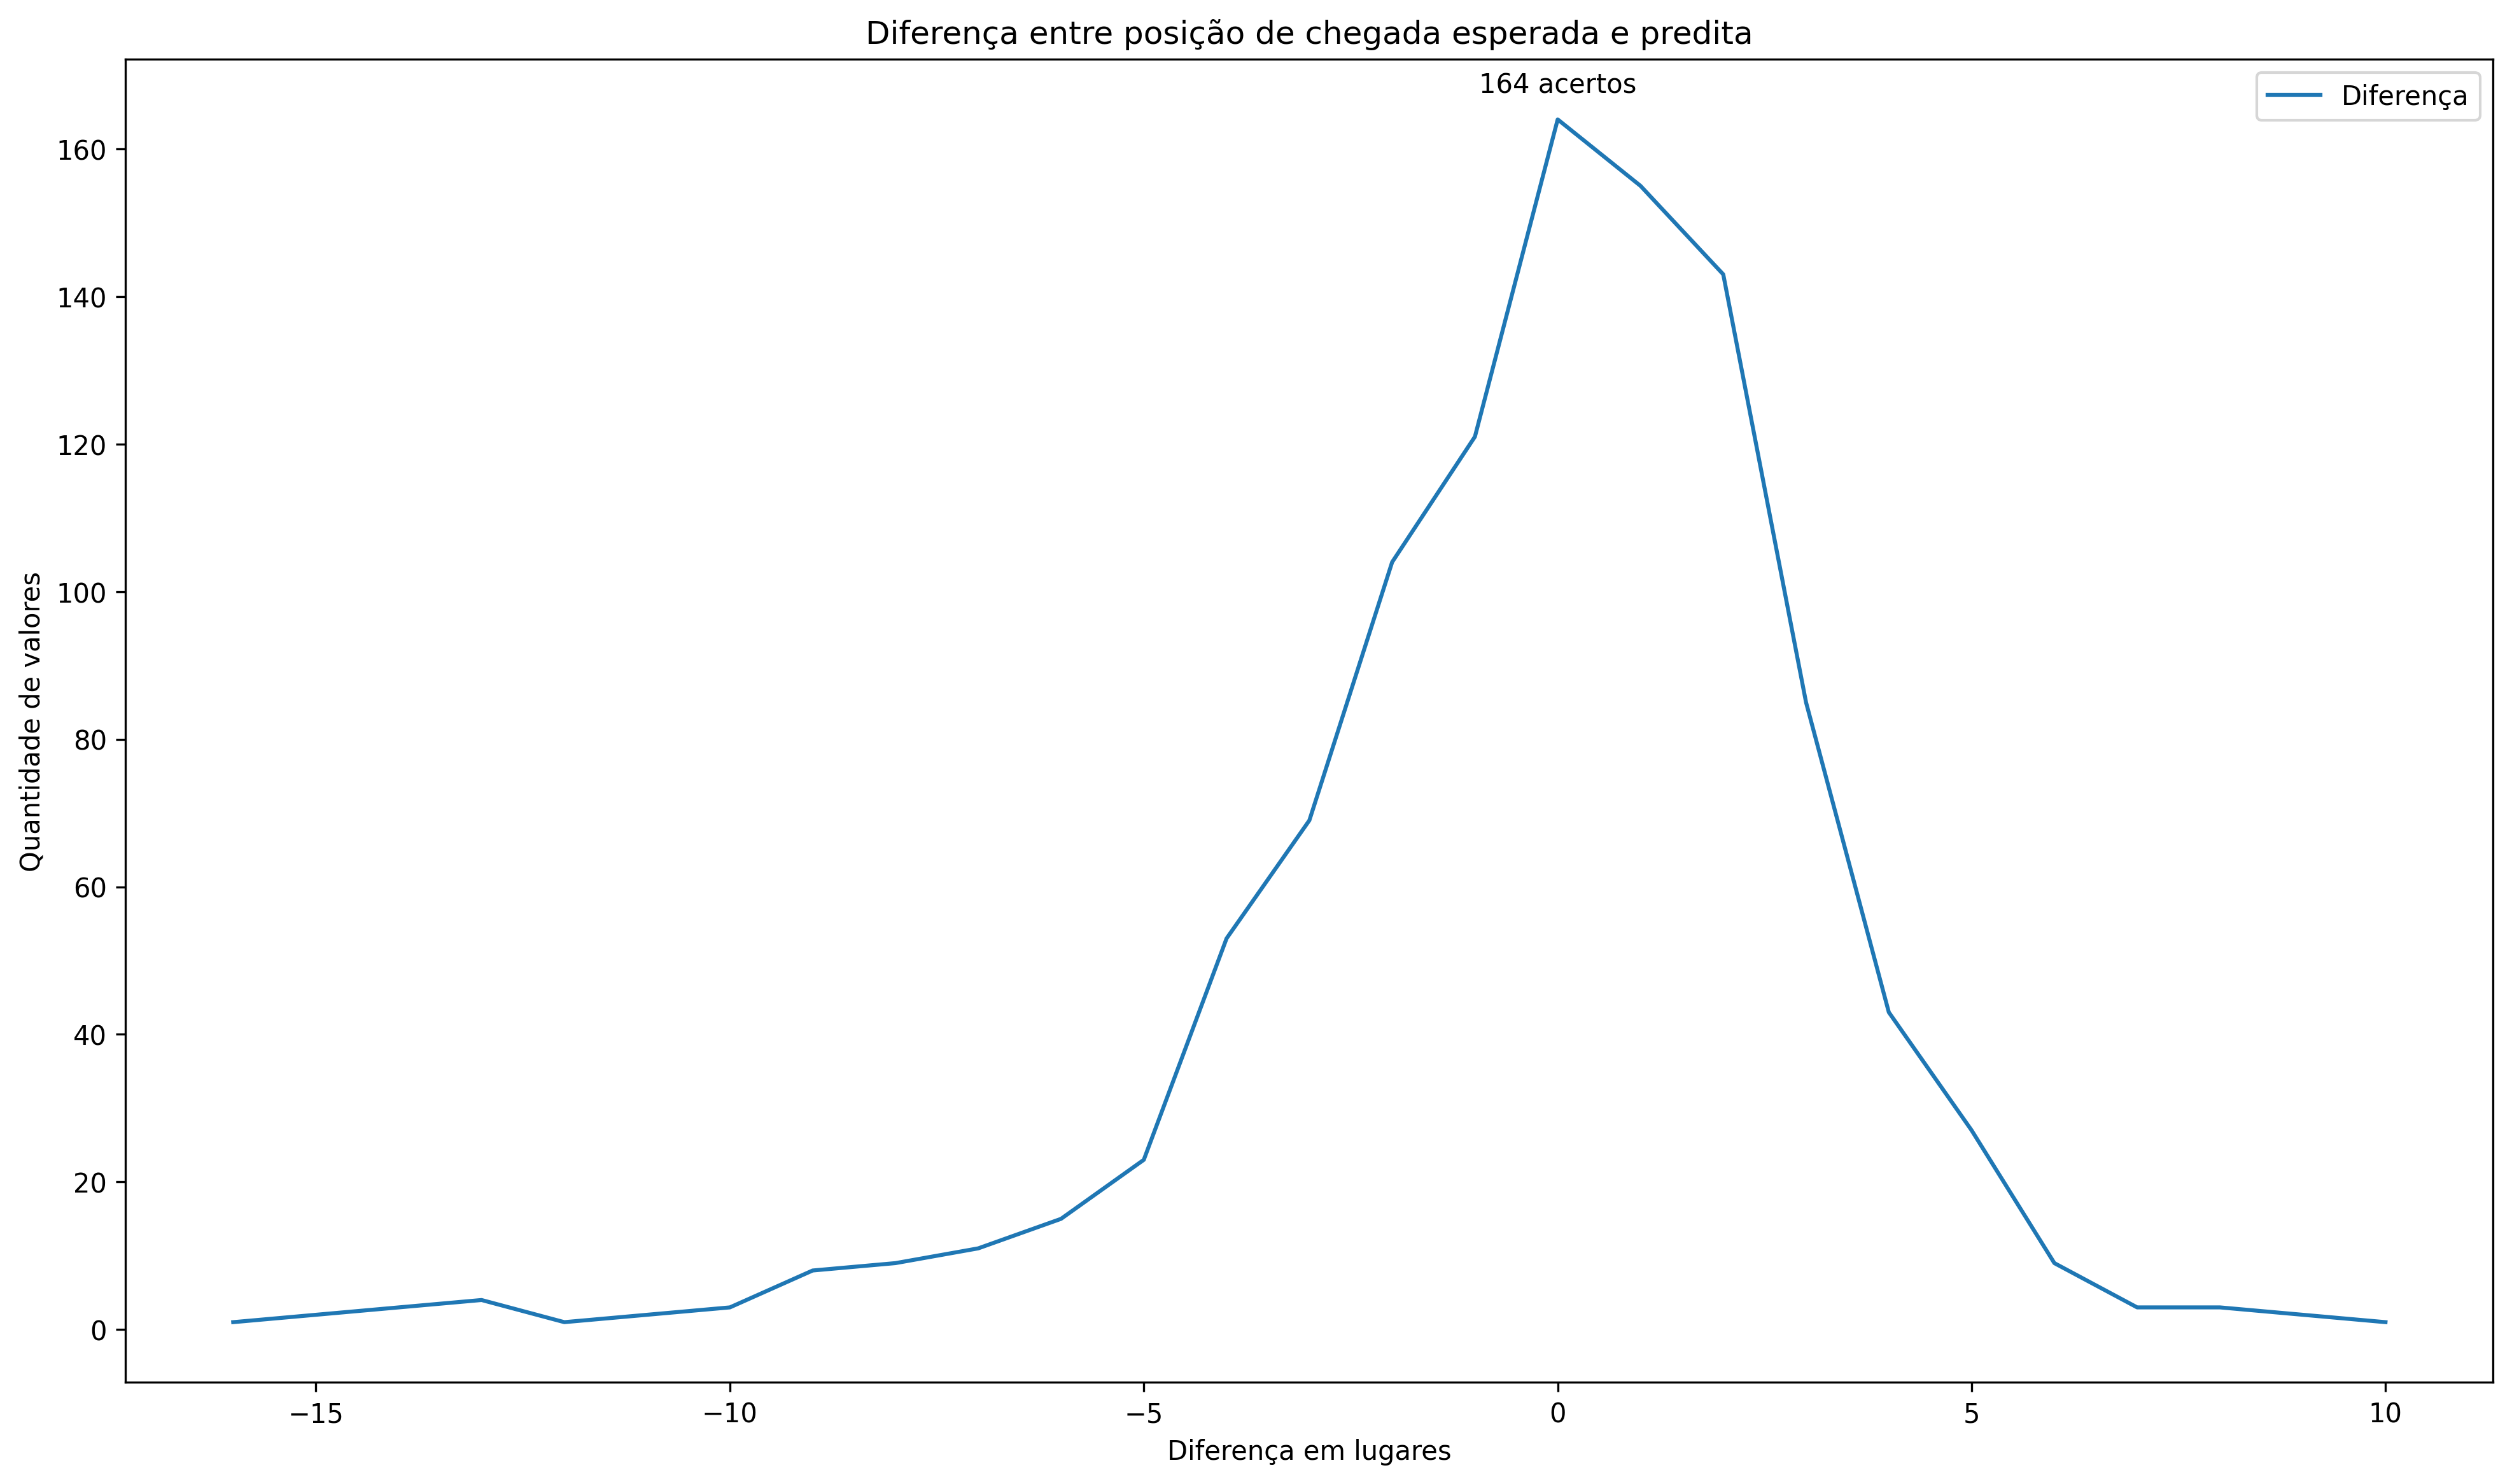

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
delta_count = test_df2['delta'].value_counts().sort_index()
ax.plot(delta_count, label='Diferença')
ax.set_xlabel('Diferença em lugares')
ax.set_ylabel('Quantidade de valores')
ax.set_title('Diferença entre posição de chegada esperada e predita')
ax.annotate(f'{delta_count[0]} acertos', (0, delta_count[0]), textcoords="offset points", xytext=(0,10), ha='center')
ax.legend()
plt.savefig('.graphs/random_forest_delta.png', dpi=300, transparent=True)
plt.show()

Agrupando os resultados esperados e verificando a média dos preditos e a diferença. É gerado um gráfico que demonstra o intervalo de confiança para cada valor predito.

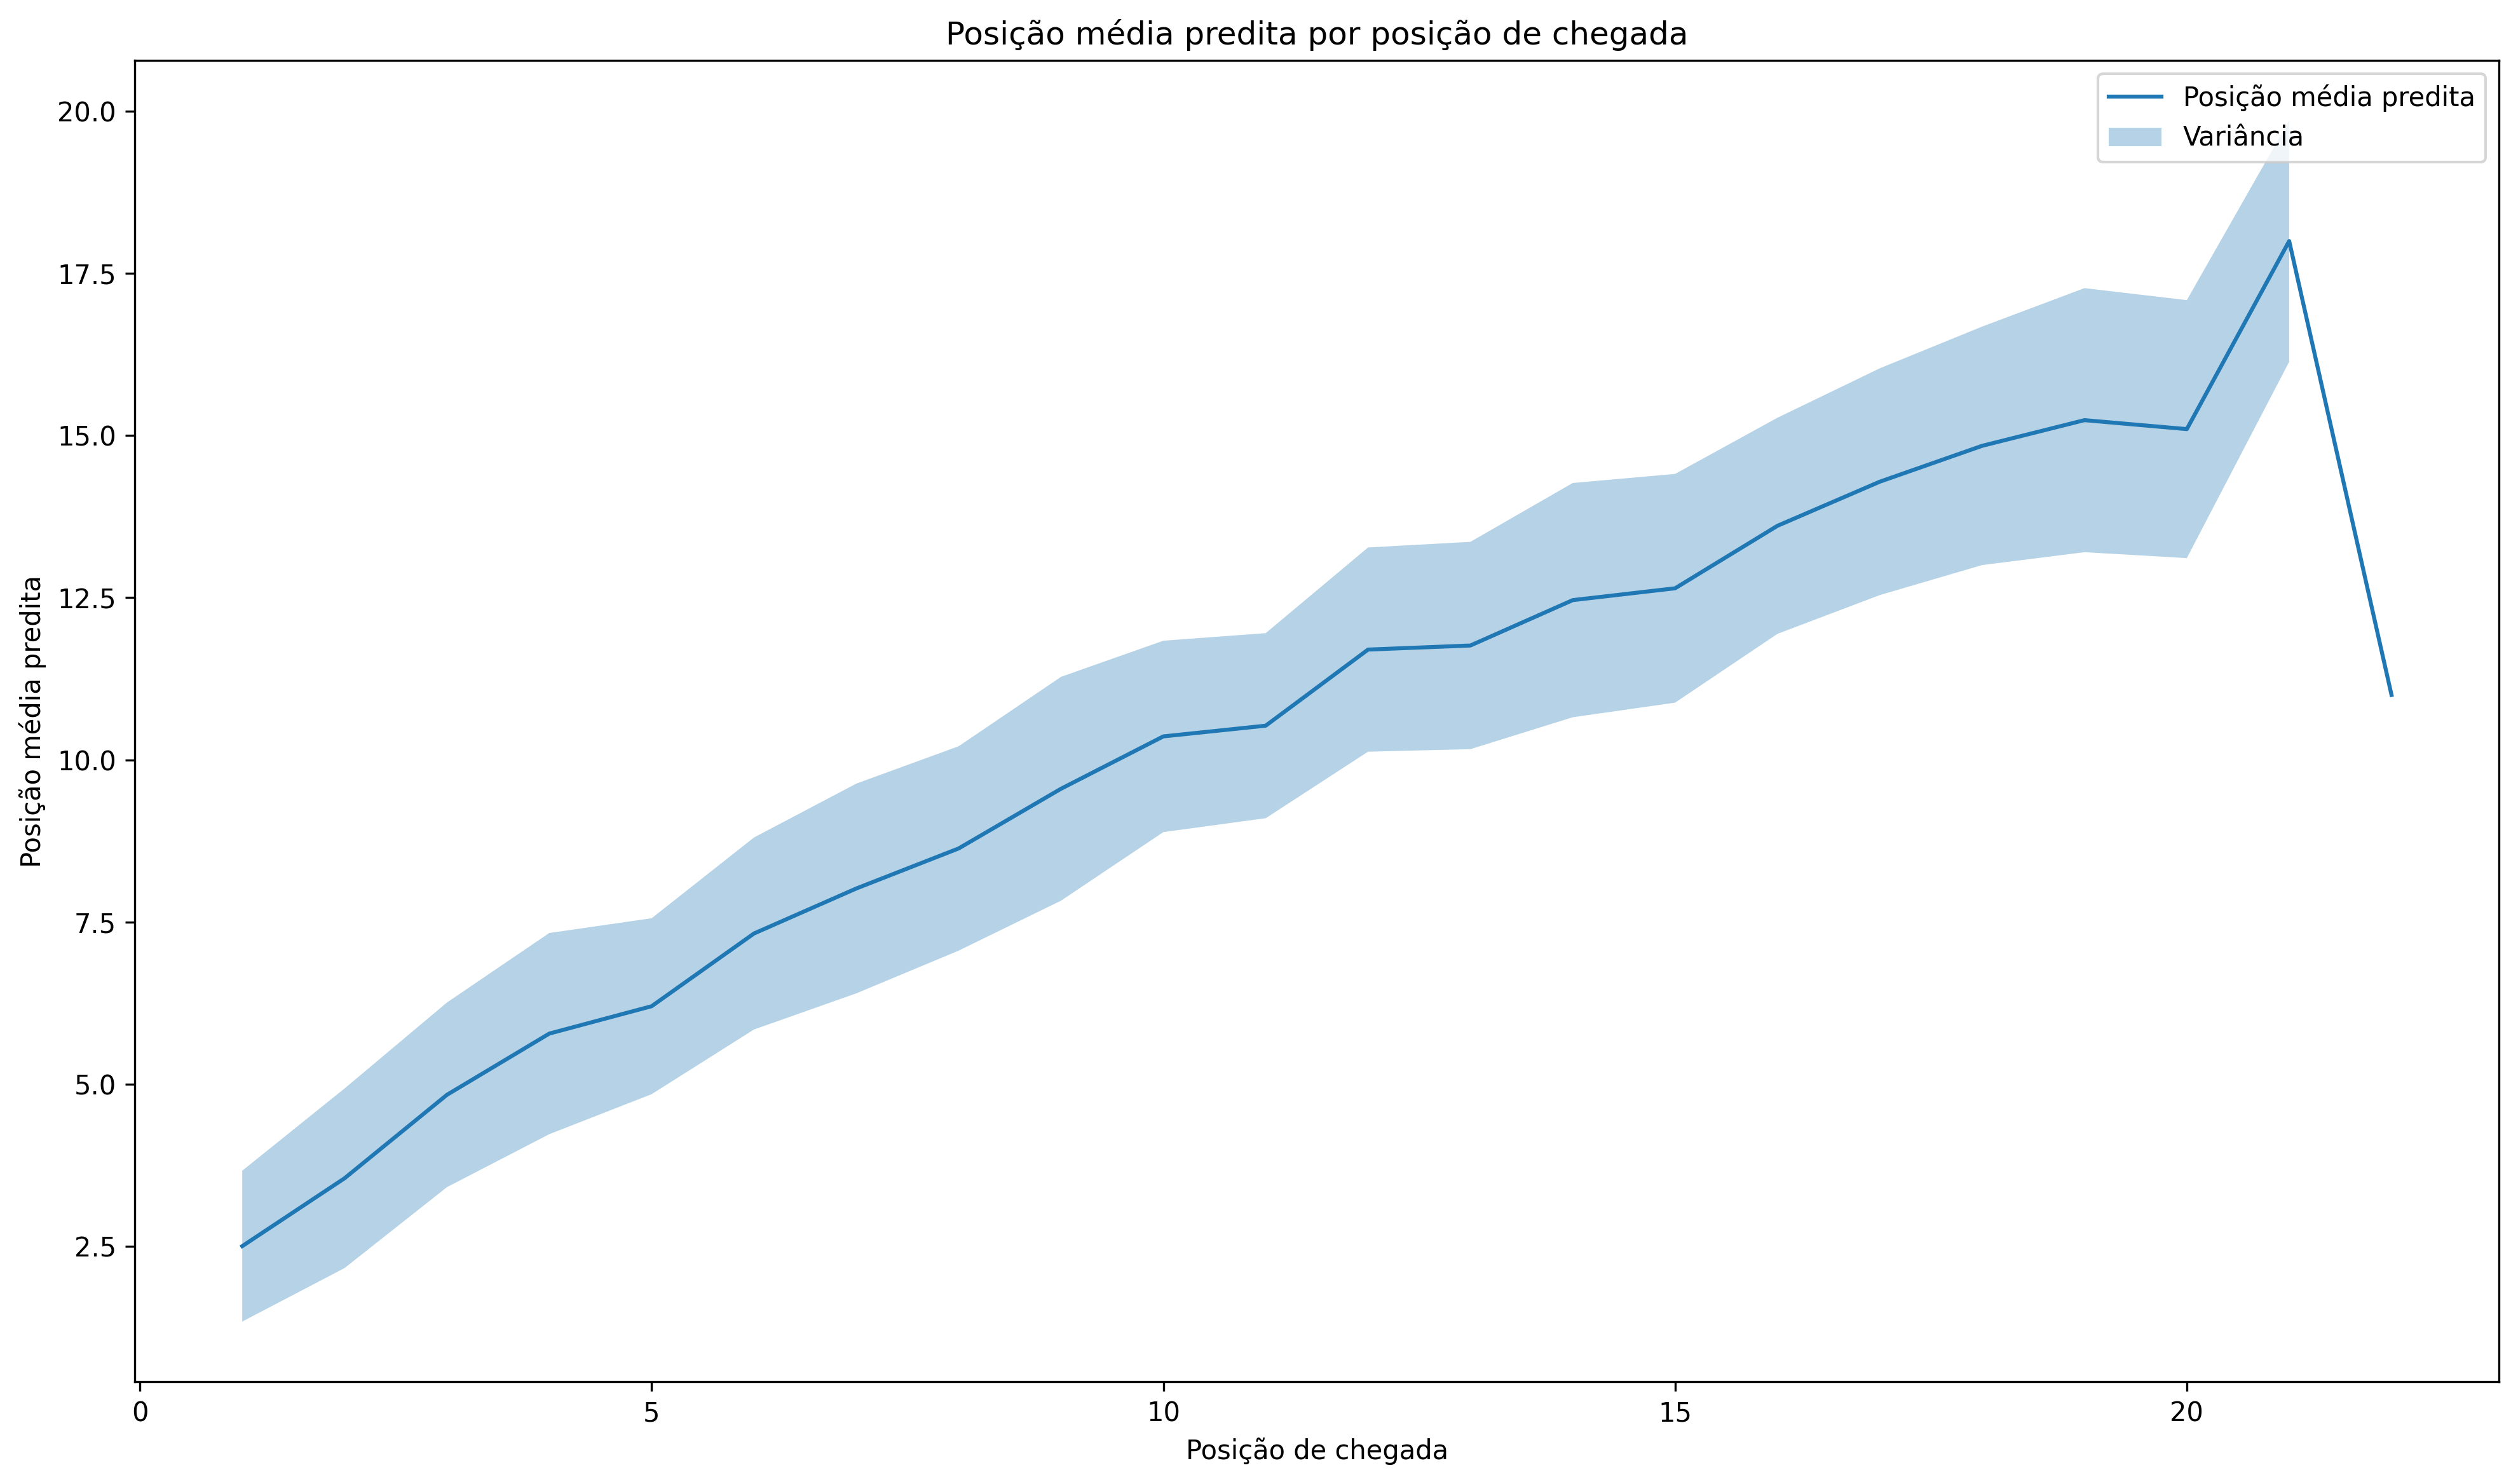

In [30]:
prediction_stats_df2 = (
    test_df2
    .groupby('position')[['predicted_position', 'delta']]
    .agg(['mean', 'min', 'max', 'std'])
)
prediction_stats_df2.columns = ['_'.join(col).strip() for col in prediction_stats_df2.columns.values]

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(prediction_stats_df2['predicted_position_mean'], label='Posição média predita')
ax.fill_between(
    prediction_stats_df2.index,
    prediction_stats_df2['predicted_position_mean'] - np.sqrt(prediction_stats_df2['predicted_position_std']),
    prediction_stats_df2['predicted_position_mean'] + np.sqrt(prediction_stats_df2['predicted_position_std']),
    alpha=0.33,
    label='Variância'
)
ax.set_xlabel('Posição de chegada')
ax.set_ylabel('Posição média predita')
ax.set_title('Posição média predita por posição de chegada')
ax.legend()
plt.savefig('.graphs/random_forest_mean.png', dpi=300, transparent=True)
plt.show()

Ou, caso preferir, em forma de tabela.

In [31]:
display(prediction_stats_df2)

,predicted_position_mean,predicted_position_min,predicted_position_max,predicted_position_std,delta_mean,delta_min,delta_max,delta_std
position,,,,,,,,
1.0,2.500000,1.0,6.0,1.352696,1.500000,0.0,5.0,1.352696
2.0,3.547170,1.0,10.0,1.917190,1.547170,-1.0,8.0,1.917190
3.0,4.833333,2.0,11.0,2.026658,1.833333,-1.0,8.0,2.026658
4.0,5.777778,1.0,14.0,2.405937,1.777778,-3.0,10.0,2.405937
5.0,6.200000,3.0,12.0,1.839887,1.200000,-2.0,7.0,1.839887
6.0,7.321429,2.0,12.0,2.191779,1.321429,-4.0,6.0,2.191779
7.0,8.015625,2.0,13.0,2.615535,1.015625,-5.0,6.0,2.615535
8.0,8.633333,2.0,13.0,2.483619,0.633333,-6.0,5.0,2.483619
9.0,9.553571,1.0,15.0,2.978222,0.553571,-8.0,6.0,2.978222


Curiosidade, qual a diferença para a estatística do modelo anterior?

In [32]:
display(prediction_stats_df2 - prediction_stats_df)

,predicted_position_mean,predicted_position_min,predicted_position_max,predicted_position_std,delta_mean,delta_min,delta_max,delta_std
position,,,,,,,,
1.0,0.479167,0.0,1.0,0.106603,0.479167,0.0,1.0,0.106603
2.0,0.622642,0.0,1.0,0.058230,0.622642,0.0,1.0,0.058230
3.0,0.383333,0.0,1.0,0.040051,0.383333,0.0,1.0,0.040051
4.0,0.666667,0.0,3.0,0.242374,0.666667,0.0,3.0,0.242374
5.0,0.872727,2.0,2.0,0.150547,0.872727,2.0,2.0,0.150547
6.0,0.553571,1.0,0.0,-0.128025,0.553571,1.0,0.0,-0.128025
7.0,0.796875,1.0,-1.0,-0.112734,0.796875,1.0,-1.0,-0.112734
8.0,0.433333,0.0,0.0,-0.144779,0.433333,0.0,0.0,-0.144779
9.0,0.410714,0.0,-1.0,-0.304951,0.410714,0.0,-1.0,-0.304951


Por fim, mostramos uma matriz de confusão para os valores esperados e preditos.

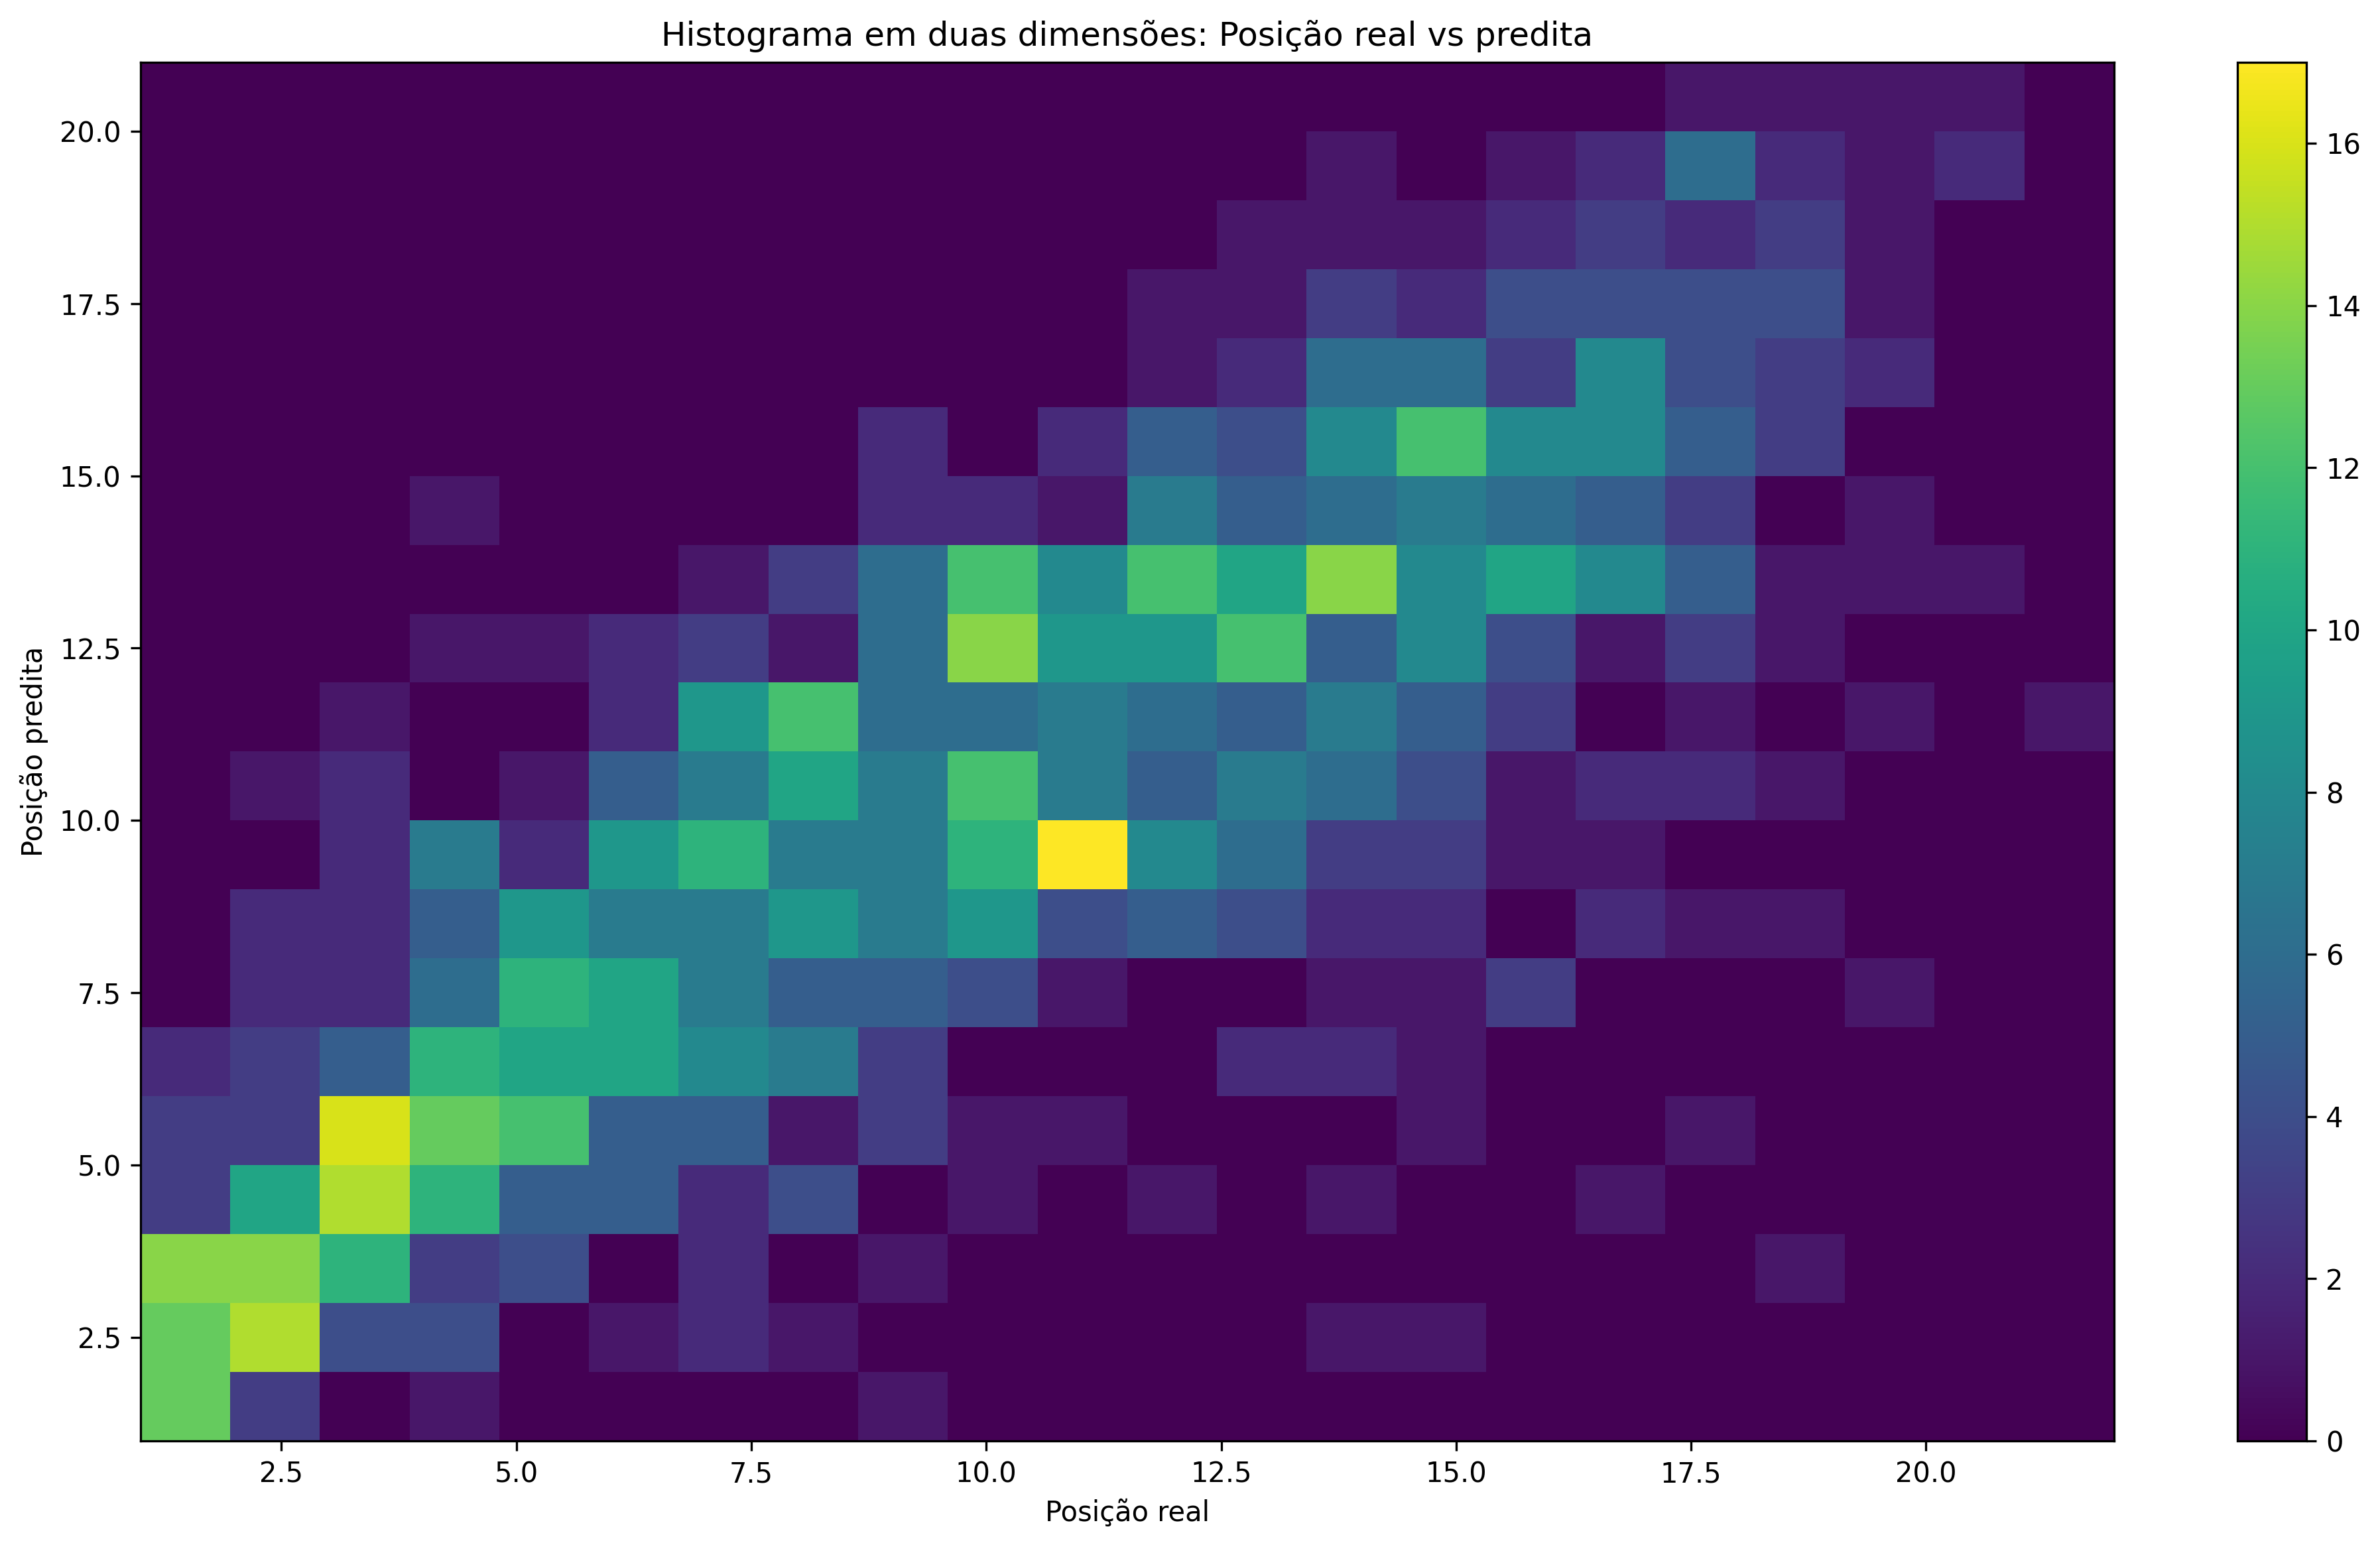

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist2d(test_df2['position'], test_df2['predicted_position'], bins=(22, 20))
ax.set_xlabel('Posição real')
ax.set_ylabel('Posição predita')
ax.set_title('Histograma em duas dimensões: Posição real vs predita')
cb = plt.colorbar(ax.collections[0], ax=ax)
plt.savefig('.graphs/random_forest_hist2d.png', dpi=300, transparent=True)
plt.show()